# Assignment 3: Score Based Generative Modeling Through Stochastic Differential Equations

In this assignment, you will be implementing architectures seen in the paper Scored Based Generative Modeling Through Stochastic Differential Equations, which we saw in the tutorials connects between the two methods you have already implemented. Due to this already being the third assignment, there will be less guidance throughout the exercise and you will have more of a free hand. Remember to turn off machines when you're not using them, and to frequently save checkpoints of your models!

The free hand means that documentation is important. We expect non-trivial functions to be documented. Additionally, we expect (brief) explanations in the notebook of how you chose to implement each part of the assignment. Good luck!

## Submission Guidelines

- If it is more comfortable, you may submit either a python project with several files which define functions or a single python notebook that implements everything. The python notebook should include outputs, even if they are not the same outputs as the ones you submit in the zip.
- If you choose to submit using a python project, you must also submit a notebook that runs all relevant functions and generates all outputs (they don't need to be the same as the ones that are in the visualization zip, but we should be able to see that all functions run correctly). There should be two zips in this case: one containing all code files (including the notebook that replicates the outputs) and another containing the visualizations as done before.
- You may name the zip files as you wish, as long as your ID is in the name.
- All other requirements are based on the requirements in the syllabus.
- Reminder: You can play with the functions as much as you want to, and don't need to implement functions using the same parameters / names as what we provide. All changes that you make should be documented and should still do all the things you're required to do.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

## Part 1: Visualizing SDEs Using Simulations

In this part, we will recreate part of Figure 2 in https://arxiv.org/pdf/2011.13456 using Euler's method for sampling from SDEs. In particular, we will be recreating the Variance Preserving SDE (DDPM's continuous form):

$$
d\textbf{x}_t = -\frac{1}{2}\beta_t \textbf{x}_t dt + \sqrt{\beta_t} d\textbf{w}_t
$$

Note that in the paper, Figure 2 is of the ALD based SDE, so it looks different than what you will be creating. Throughout this part of the assignment, we will be working with $\beta_0 = 0.1, \beta_1 = 20$, $\beta(t) = (\beta_1 - \beta_0)t + \beta_0$. $\mathbf{x}_0$ follows a mixture of Gaussians distribution, with probability 0.5 of being centered around -3 and 0.5 of being centered around 3, with standard deviation 0.5.

This part can be entirely run on your PC, without needing the VM or CUDA. We strongly recommend to run this part of the assignment locally. 

1. For $\textbf{x} \in \mathbb{R}$, formulate the ground truth distribution $p_t(\textbf{x}_t | \textbf{x}_0)$ and the function $\nabla_{\textbf{x}_t} \log p_t(\textbf{x}_t | \textbf{x}_0)$. Note $\Sigma_0 = 0$.
2. Train a simple model using the loss from tutorials 5/6 to approximate the marginal score: $\nabla_{\textbf{x}_t}\log p_t(\textbf{x}_t)$, for the above SDE.
3. Sample 100,000 values for $\textbf{x}_0$ following a mixture of Gaussians, probability 0.5 of being centered around -3 and 0.5 being centered around 3, with standard deviation 0.5. Advance them according to the SDE provided in DDPM, using Euler's method with `T=1000` and step size `1e-3`. What is the distribution we reached?
4. For 10,000 random starting points, advance them according to the probability flow ODE, using the score you learned. Note that despite the fact that you need the score to do this, *you are still advancing the points according to the forward process*! 
5. Now, reverse the process by sampling 10,000 samples from the prior distribution and taking reverse steps according to the reverse SDE using the score. To sample using Euler in the reverse process, see equation 46 in the paper linked above (in Appendix E, $\mathbf{f}\equiv \mu, \mathbf{G}\equiv \sigma$). Display the trajectory of 2 random starting points using the reverse SDE.
6. Bonus (2 points): Sample 10,000 points according to the reverse probability flow ODE and display the trajectory of two random starting points.

Display the histogram of $\mathbf{x}_t$ as a function of time using a heatmap on the $y$ axis. You can use meshgrids and `matplotlib`'s pcolormesh to display the histogram as shown below. There should be 3/4 total histograms:

1. Histogram of Euler discretization of forward SDE (100,000 starting points).
2. Histogram of Euler discretization of probability flow ODE (10,000 starting points). It's ok if the histogram isn't as nice as the SDE histogram, but points will still be deducted if it's very different in general behavior.
3. Histogram of Euler discretization of reverse SDE (10,000 starting points). It's ok if it isn't exactly the reverse of the forward SDE, but points will still be removed if there are mistakes in the code.
4. (Bonus) Histogram of Euler discretization of reverse probability flow ODE (10,000 starting points).

Expected outputs for first histogram:

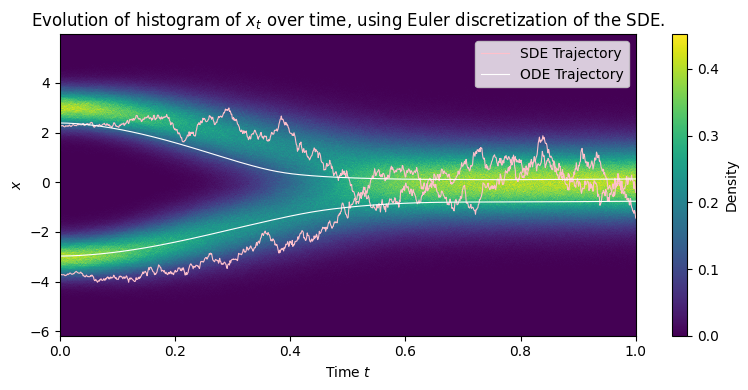

## Part 2: Implementing DDPM as a Score Network

This part (and all following parts) will require a GPU, so you should run it on the machines we provided.

Note that parts 2 and 3 should heavily rely on your existing DDPM code. Not much has to change.

In the recent tutorials, we showed how the training procedures for DDPM and ALD are actually equivalent, and that using a basic transformation, we can view a model trained according to the DDPM loss as a model that approximates the score. In this part we will show how this is true.
1. Train a DDPM model the same way you trained in HW2, using either MNIST from HW1 (recommended) or Fashion MNIST from HW2. The only difference should be that time ($t$) should be between 0 and 1 as opposed to 1 and $T$. Note that because the time is now of a different scale, we may need to use a different method for time encoding. For now, $\beta(t) = \beta_{t*T}$.
2. Fill in the function ```get_score_model``` that accepts a model that was trained according to the DDPM loss and returns a new model that approximates the score (note that this is a nested function, meaning it returns a function).
3. Sample from the model using the score model, using what we saw in tutorials 5/6 and the sampling method above, or using Ancestral Sampling (shown in Equation 4 in the paper linked in part 1 and in tutorial 4). Display 64 sampled images.

In [ ]:
def get_score_model(ddpm_model, ddpm_sqrt_1m_alpha):
    def score(x_t, t):
        # YOUR CODE HERE
        pass
    return score

## Part 3: True SDE Implementation

In the previous part, we still used the $\alpha_t$ notations. Now, we will get rid of them and instead implement a true SDE based model, based on the DDPM SDE (variance preserving). We assume a linear $\beta_t$ schedule like before, meaning that the integral to compute the conditional mean can be computed. Remember that now the continuous transformation of $\beta_t$ is $\beta(t)=T\beta_i$ for $i=Tt$. Tip: remember that the continuous version's means should be similar to $\alpha_i$ in the discrete case.

1. Fill in the classes `DDPM_SDE`, `UnifiedLoss`. For the loss, you can either use the score matching loss (less recommended) or the regular noise matching loss. If you use the noise matching loss, implement a function `get_score_model_continuous(model, sde)` that transforms your model that approximates noise to a model that approximates the score. Remember that for $t=0$, we may have a problem defining the std=0, so we can define a small std instead. Implement `train_sde`. 
2. Fill in the class `AncestralSamplingContinuous`. This class can either sample using what we saw in part 2 or using Euler's method on the reverse DDPM SDE as implemented in part 1. Implement `sample_images` which should denoise images. Note that the final sampling step should add 0 noise.

Again, note that not much has to change in this part, except now $\beta$ should be implemented as a function and not a sequence, $\alpha_t$ is replaced with the calculation from the tutorial.

In [ ]:
class DDPM_SDE:
    def __init__(self, beta_0, beta_1, T_discrete, device):
        """beta_0, beta_1: The original beta_1, beta_T."""
        pass

    def beta(self, t):
        """
        t in [0, 1], can be any real value in this interval and is not restricted to the discrete time steps. In reality, t is a batch vector.
        """
        pass

    def drift_diffusion(self, x_t, t):
        """
        x_t: (batch_size, channels, height, width)
        t: (batch_size,)

        Return the drift coefficient (mu) and the diffusion coefficient (sigma) of the SDE at time t and the current x_t.
        """
        pass

    def distribution(self, x_0, t):
        """
        x_0: (batch_size, channels, height, width)
        t: (batch_size,)
        Return the distribution of x_t conditioned on x_0 and t.
        """
        pass

    def reverse_drift_diffusion(self, score_fn, x_t, t):
        """
        score_fn: function that takes x_t and t and returns the score
        x_t: (batch_size, channels, height, width)
        t: (batch_size,)
        Return the drift coefficient (mu) and the diffusion coefficient (sigma) of the reverse SDE at time t and the current x_t.
        """
        pass

In [ ]:
class UnifiedLoss(nn.Module):
    def __init__(self, sde, model):
        pass

    def forward(self, x):
        """
        x is a batch of images (batch_size, channels, height, width).
        """
        pass

In [ ]:
class AncestralSamplingContinuous(nn.Module):
    def __init__(self, sde, model):
        pass

    def forward(self, x_0):
        """
        x_0: (batch_size, channels, height, width). x_0 is the original noise.
        Remember that the final step of the SDE should not sample any random noise and should be deterministic.
        To know how many steps to do, use T_discrete from the SDE.
        x_0 is the original noise. Return a list of images for each 100 steps.
        """
        pass

In [ ]:
def train_sde():
    """
    Write a function that trains the SDE model on our dataset and saves its weights to a checkpoint. 
    Recommendations for stability: use torch.nn.utils.clip_grad_norm_ to clip the norm of the loss.
    """
    pass

In [ ]:
def sample_images():
    """
    Sample images according to the SDE, model and display / save them. Feel free to change this function as much as you'd like, the given implementation is for you.
    Remember if the model is a noise matching model, you should perform the transformation to turn it into a score model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = None  # Replace with the class of your model.
    ckpt = torch.load("model.pth", map_location=device, weights_only=True)  # Replace with the path to your model checkpoint. Load the trained model's weights
    model.load_state_dict(ckpt["model"])
    sde = DDPM_SDE(beta_0=1e-4, beta_1=0.02, T_discrete=1000, device=device)  # Replace with the parameters of your SDE. These parameters should work, but feel free to change them if they don't work for you.
    sampler = AncestralSamplingContinuous(sde, model).to(device)

    noisy_images = torch.randn(16, 1, 28, 28).to(device)  # Replace with the shape of your images.
    with torch.no_grad():
        sampled_images = sampler(noisy_images)
    sampled_images = sampled_images.cpu().numpy()

    ### ADD CODE TO DISPLAY / SAVE THE IMAGES ###


Example output:

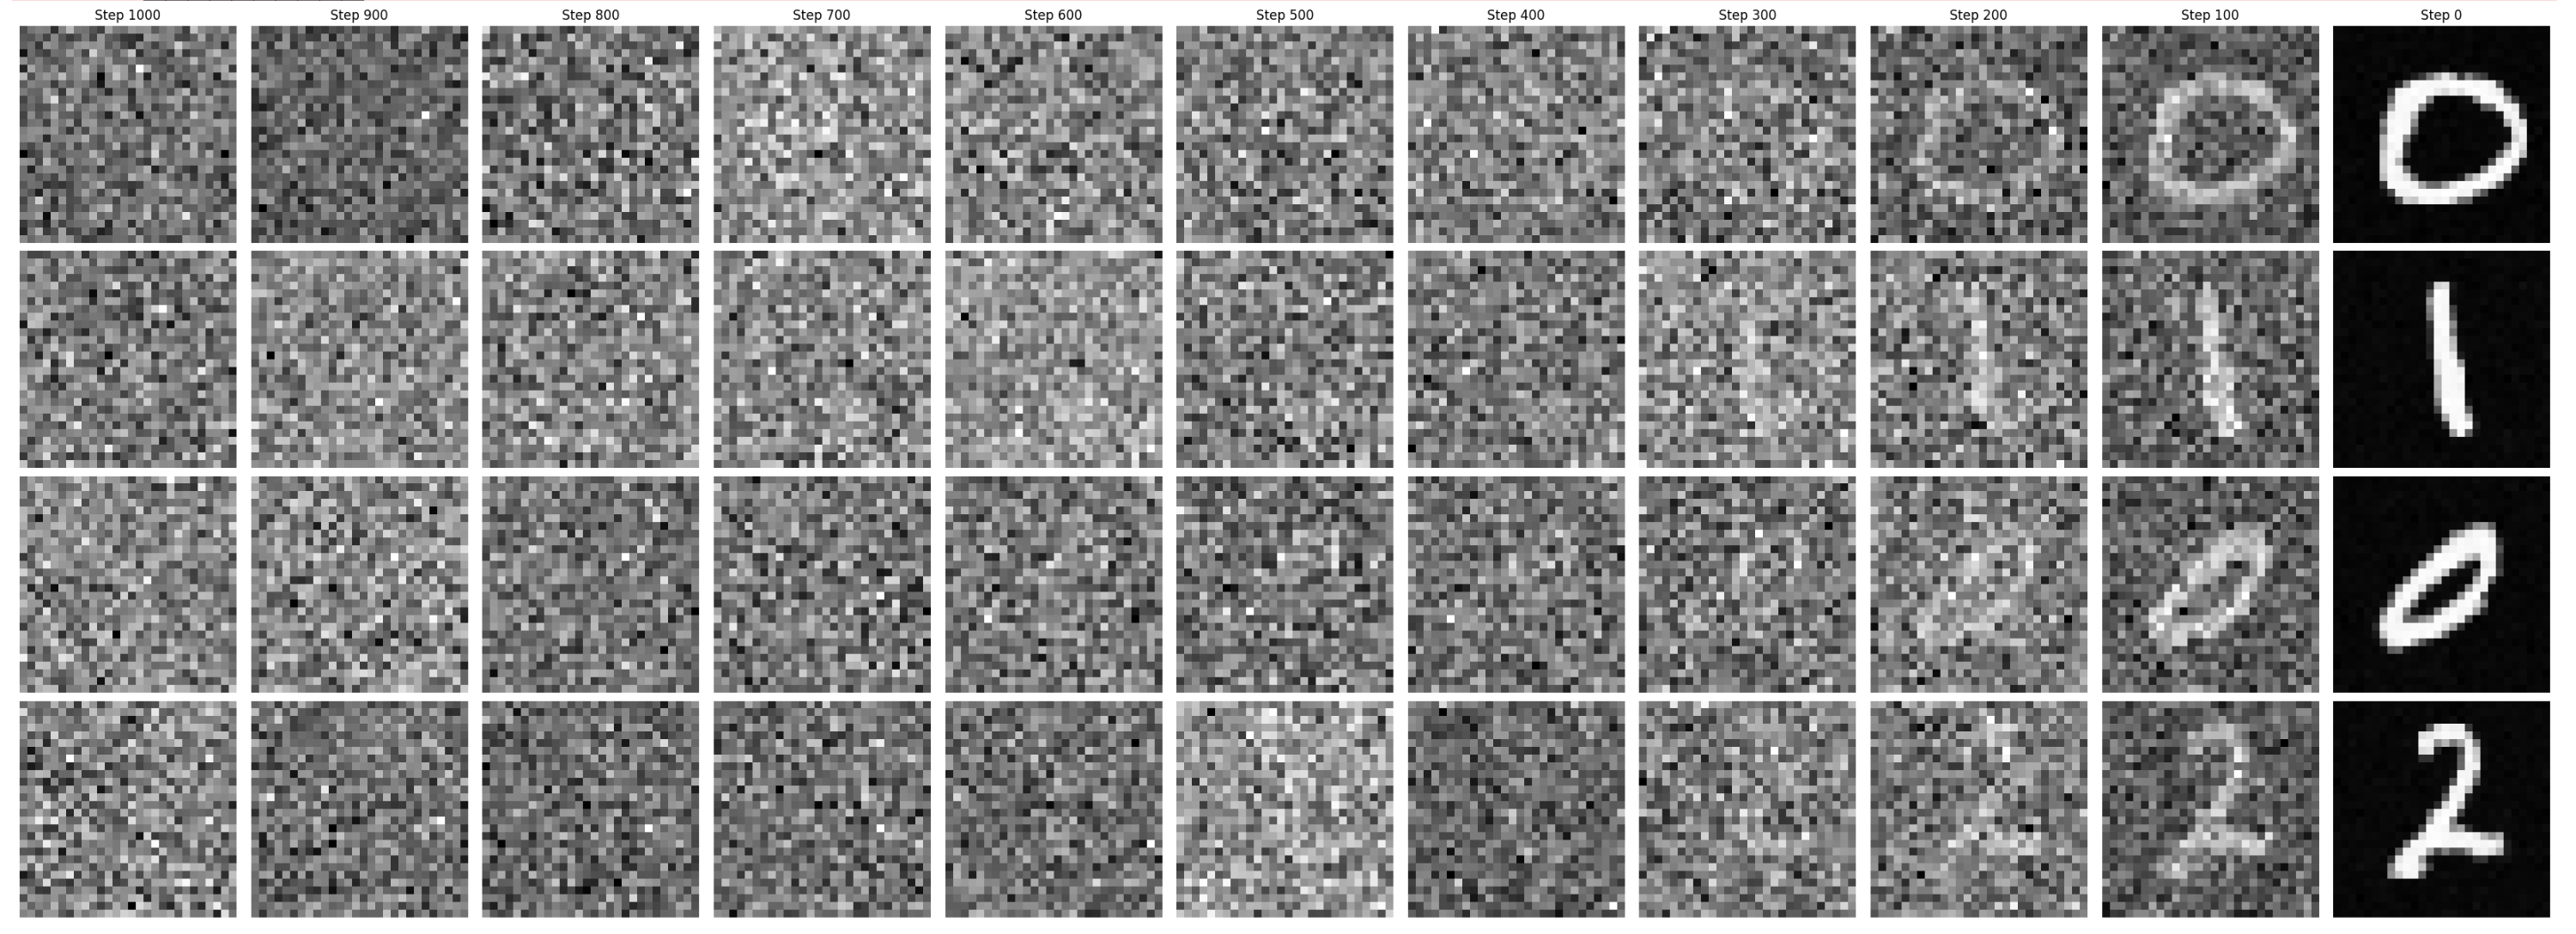

## Part 4: Conditional Generation

In this part, we will use the model we already trained along with a classifier to generate images that are conditioned on a certain class. Specifically, if we are using MNIST we will generate images of the number 5 and if we are using Fashion MNIST we will generate images of sandals (label 5). Note that the training in this section shouldn't take much time as we are using relatively simple datasets, and we are not training a new score model.

For help in this part, we refer you to the variety of open source implementations of this architecture.

1. Train a CNN classifier on your chosen dataset, noising the images according to the SDE to help the model deal with the noisy images that it will receive in generation. The classifier should reach at least 90% accuracy on the test set without noise (and in reality should reach even 98%+). You can choose to either implement $p_t(y|x)$ or just $p(y|x)$ (time can be an input to the CNN if you wish, not necessary for good enough results).
2. Use the score model from part 3 along with the classifier to sample images using classifier guidance. Sample using the same method of sampling that you chose in part 3, replacing the original score with the new "score". Play with the hyperparameter $\gamma$ (at least 3 different positive values) and briefly explain how different values of $\gamma$ influence the generated images. Generate 64 conditional images for each $\gamma$.
3. For the largest $\gamma$ you choose, run the classifier that you trained on the 64 images you generated. You should reach at least 70% accuracy on these images (meaning the classifier guidance should generate a majority of images that look like the correct class).

Not all images need to be perfect, for example the following output is acceptable for $\gamma=1$.

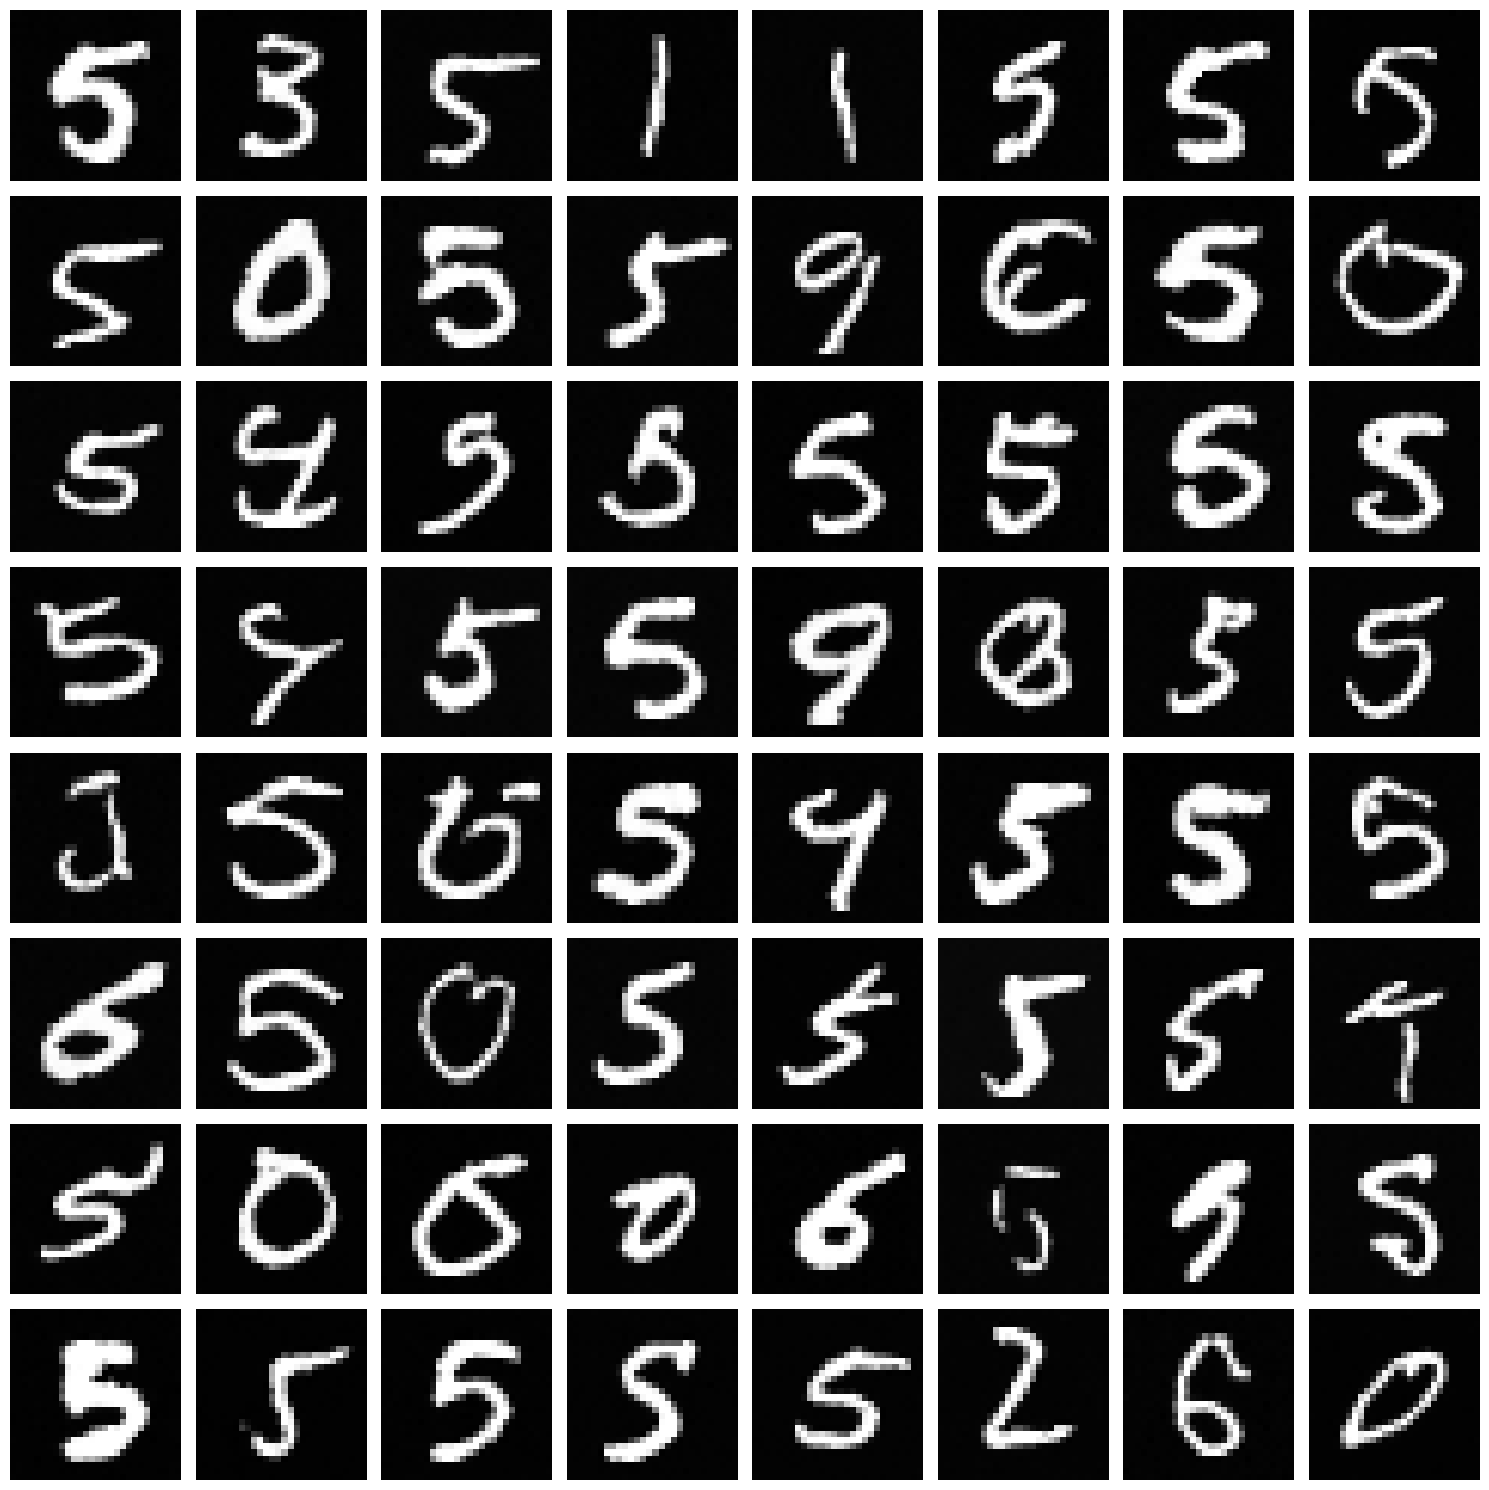